# MOEA tutorial

In the previous assignments, we have been using sampling to investigate the uncertainty space and the lever space. However, we can also use optimization algorithms to search through these spaces. Most often, you would use optimization to search through the lever space in order to find promising policies. However, we can also use optimization to search through the uncertainty space in order to find for example a worst case scenario. In this assignment, we are going through the basics of using the optimization functionality of the workbench. 

For optimization, the ema_workbench relies on a library called platypus-opt. *platypus-opt* is python package developed by David Hadka (http://platypus.readthedocs.io/en/latest/) for multi-objective optimization. It allows an explicit specification of the problem components (levers, objectives, constraints). The package includes several multi-objective evolutionary algorithms, therefore the users can choose the algorithm they wish to use. 

you can use pip to install it:

```
pip install platypus-opt
```

Start with importing the lake model we have used in previous weeks and connecting it to the workbench. However, we need to make one change: for each outcome of interest we need to specify whether we want to maximize or minimize it, we can use the `kind` kwarg for this. `max_P` should be minimized, while all other outcomes are to be maximized. As a further simplification for this tutorial, we are ignoring the inertia objective. We do this by not setting the `kind` kwarg. 


In [1]:
from lakemodel_function import lake_problem

from ema_workbench import (Model, RealParameter, ScalarOutcome,
                           MultiprocessingEvaluator, ema_logging,
                           Constant)

ema_logging.log_to_stderr(ema_logging.INFO)

#instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE)]

lake_model.constantcs = [Constant('alpha', 0.41),
                         Constant('reps', 150)],

Instead of using `perform_experiments`, we will be using `optimize`. There is several kwargs that we need to provide, so let's go through all:

* **algorithm**; We can specify which algorithm we want to use. The default is $\epsilon$-NSGA2, a state of the art many-objective evolutionary algorithm. We can use any of the other algorithms that come with platypus-opt, or the GenerationalBorg algorithm that comes with the workbench. For now, we won't change this.
* **nfe**; the number of function evaluations, this is to be determined by analyzing whether the algorithm has converged
* **searchover**; are we optimizing over the uncertainties or the levers? Most often we will be searching over the levers, so we don't generally need to change this. 
* **reference**; If we are searching over levers, what values should we assume for the uncertainties? Reference allows us to specify this. If searchover is set to levers, reference should be a `Scenario` or None, while if searchover is uncertainties, reference should be a `Policy` or None. In case of a None, the default values of the underlying model are unchanged
* **constraints**; see below
* **epsilons**; many state of the art MOEA's rely on a epsilon dominance. Basically, a grid is imposed on the objective space, and per grid cell a single solution is maintained. The granularity of the grid is specified through the epsilon values. Epsilon should be a list or array with a length equal to the number of outcomes. Below, we will see what the impact is of changing epsilon values.
* **convergence**; In order to track whether a MOEA has converged to the optimum solutions, we use convergence metrics. The workbench offers epsilon progress and hypervolume as two often used metrics for this. We will explore these below. 

let's start with a simple optimization using 5000 nfe, and the 0.25, 0.1, and 0.1 as epsilon values. 

In [2]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    results = evaluator.optimize(nfe=5000, epsilons=[0.25, 0.1, 0.1])

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/INFO] generation 5: 500/5000 nfe
[MainProcess/INFO] generation 10: 1000/5000 nfe
[MainProcess/INFO] generation 15: 1500/5000 nfe
[MainProcess/INFO] generation 20: 2000/5000 nfe
[MainProcess/INFO] generation 25: 2500/5000 nfe
[MainProcess/INFO] generation 30: 3000/5000 nfe
[MainProcess/INFO] generation 35: 3500/5000 nfe
[MainProcess/INFO] generation 40: 4000/5000 nfe
[MainProcess/INFO] generation 45: 4500/5000 nfe
[MainProcess/INFO] optimization completed, found 8 solutions
[MainProcess/INFO] terminating pool


Since we are dealing with 3 outcomes of interest, we can still visualize our results in a 3d scatter plot. Alternatively, we can visualize it using a so-called parallel coordinate plot. In a parallel coordinate plot, the dimensions are visualized side by side. A line connecting the dimensions is a single point in the multidimensional space. For more than 3 dimensions, parallel coordiante plots are prefered over 3d scatter plots with additional visual encodings for the other dimensions. The workbench has support for parallel coordinate plots using `ema_workbench.analysis.parcoords`

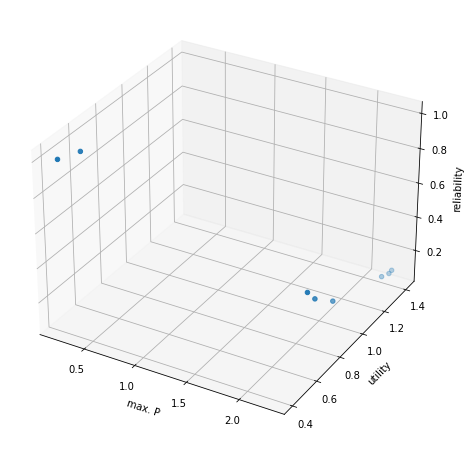

In [4]:
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt
outcomes = results.loc[:, ['max_P', 'utility', 'reliability']]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(outcomes.max_P, outcomes.utility, outcomes.reliability)
ax.set_xlabel('max. P')
ax.set_ylabel('utility')
ax.set_zlabel('reliability')
plt.show()

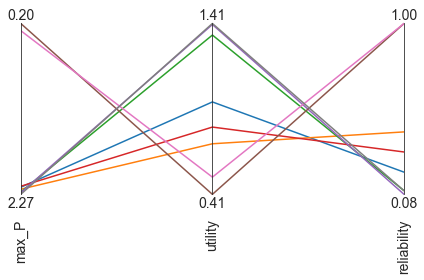

In [5]:
from ema_workbench.analysis import parcoords

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same 
axes.invert_axis('max_P') 
plt.show()


As you can see, the parcoords figure is easier to interpret once you have learned how to read them. We can see a clear tradeoff between max_P and reliability on the one hand, and utility on the other. This is indicated by the crossing lines in between these respective dimensions. 

for the remainder of this tutorial, we will be using a four objective formulation of the problem. We add the intertia objective and we want to maximize it.

In [6]:
#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE)]

## Exploring alternative epsilon values

An important user specified parameter when using $\epsilon$-NSGAII is the epsilon parameter. $\epsilon$-NSGAII uses what is known as $\epsilon$ dominace rather than normal Pareto dominance. The idea is that a grid is imposed on the objective space, and that per grid cell, one solution is maintained. The figure below shows 2 different griddings impossed on a 2D objective space. As can be seen, the left hand figure uses an $\epsilon$ value of 0.1 for both the X and Y axis. The right hand figure uses 0.2 for the X-axis and 0.1 for the Y-axis.


<div>
<img src="figs/fig_epsilons_300dpi.png" width="800"/>
</div>


But which point is retained if you have multiple points within a single grid cell? The figure below shows how this works. Assume that we are minimizing on both $x$ and $y$, then the origin of the grid cell is the lower left corner. Next, we calculate the Euclidian distance from each point within the cell to the origin. We retain the point with the lowest Euclidian distance to the origin.

<div>
<img src="figs/fig_euclidian_300dpi.png" width="400"/>
</div>



So what are the consequences of using different epsilon values? Let's rerun the optimization, but with different epsilon values. Use \[0.5, 0.5, 0.5, 0.5\]

In [7]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    results = evaluator.optimize(nfe=5000, epsilons=[0.5, 0.5, 0.5, 0.5])

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/INFO] generation 5: 500/5000 nfe
[MainProcess/INFO] generation 10: 1000/5000 nfe
[MainProcess/INFO] generation 15: 1500/5000 nfe
[MainProcess/INFO] generation 20: 2000/5000 nfe
[MainProcess/INFO] generation 25: 2500/5000 nfe
[MainProcess/INFO] generation 30: 3000/5000 nfe
[MainProcess/INFO] generation 35: 3500/5000 nfe
[MainProcess/INFO] generation 40: 4000/5000 nfe
[MainProcess/INFO] generation 45: 4500/5000 nfe
[MainProcess/INFO] optimization completed, found 2 solutions
[MainProcess/INFO] terminating pool


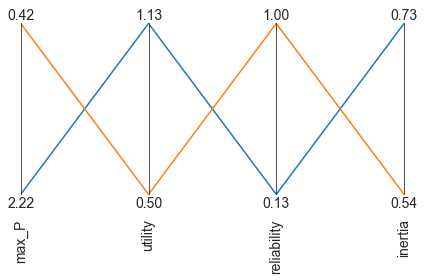

In [8]:
outcomes = results.loc[:, ['max_P', 'utility', 'reliability', 'inertia']]

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same 
axes.invert_axis('max_P') 
plt.show()

We see that by making our epsilons higher, we are coursening the grid, and thus are reducing the number of solutions we find. Let's test this by making our epsilons smaller. We now expect to find more solutions. Let's use \[0.125, 0.05, 0.05\]

In [9]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    results = evaluator.optimize(nfe=5000, epsilons=[0.125, 0.05, 0.05, 0.05])

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/INFO] generation 5: 500/5000 nfe
[MainProcess/INFO] generation 10: 1000/5000 nfe
[MainProcess/INFO] generation 15: 1500/5000 nfe
[MainProcess/INFO] generation 20: 2000/5000 nfe
[MainProcess/INFO] generation 25: 2500/5000 nfe
[MainProcess/INFO] generation 30: 3000/5000 nfe
[MainProcess/INFO] generation 35: 3500/5000 nfe
[MainProcess/INFO] generation 40: 4000/5000 nfe
[MainProcess/INFO] generation 45: 4500/5000 nfe
[MainProcess/INFO] optimization completed, found 39 solutions
[MainProcess/INFO] terminating pool


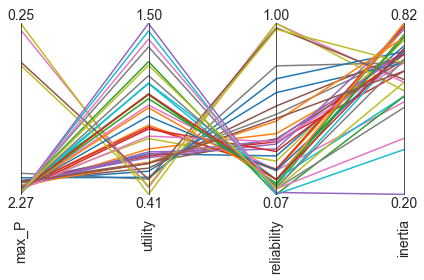

In [10]:
outcomes = results.loc[:, ['max_P', 'utility', 'reliability', 'inertia']]

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same 
axes.invert_axis('max_P') 
plt.show()

And as expected, we now have many more solutions. Selecting appropriate epsilon values is tricky. It depends on case specific concerns (with what granularity do we want to find solutions?), as well as runtime considerations. The lower the epsilon values, the more solutions will be maintained in the Pareto set. Given how MOEA's work, this slows down the optimization. 

## Assessing convergence
Next to selecting appropriate epsilon values, a second key issue is assessing convergence. In the foregoing, we have been running the MOEA for 5000 function evaluations. Is this sufficient? Has the algorithm converged? We have no idea. So, how can we add convergence assessment? 

There exist a variety of metrics for assessing convergence of MOEAs. The workbench supports epsilon progress and hypervolume. Epsilon progress measures how often a solution in a new grid cel of the epsilon gridded output space is found. Early on, solutions in new grid cells are found quite frequently. Once the algorithm starts to converge, progress becomes more difficult and thus epsilon progress starts to stabilize. Hypervolume is a measure for how much of the objective space is covered by a given set of non-dominated solutions. THe higher the hypervolume, the larger the space is that is covered by the space. Again, hypervolume will grow quickly early on and starts to stabilize once the algorithm is converging. 

So exactly what is hypervolume. In the figure below, the idea of hypervolume is explained visually. Let's assume we have two objectives, $x$ and $y$, which we both want to minimize. Then, in light grey you see a number of points which are being dominated by the points in blue. Hypervolume is based on these non dominated blue points. The orange shaded area is the hypervolume of this set, given that we measure it from the (1, 1) top right corner.

<div>
<img src="figs/fig_hypervolume_300dpi.png" width="400"/>
</div>

Since hypervolume requires specifying the objective space within which we want to calculate the volume (i.e. the (1,1) top right corner in the example), we need to know this space. Sometimes it is known a priori. For example in the lake problem, reliability is scalled between 0 and 1. In contrast, the bounds on max_P are not known up front. To help with this, we can introduce a constraint saying that max_P must be below a particulare threshold.


In [11]:
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
from ema_workbench import Constraint

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE,
                                     expected_range=(0,5)),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,2)),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE,
                                    expected_range=(0,1)),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1))]

convergence_metrics = [HyperVolume.from_outcomes(lake_model.outcomes),
                       EpsilonProgress()]

constraints = [Constraint("max pollution", outcome_names="max_P",
                          function=lambda x:max(0, x-5))]

In [12]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    results, convergence = evaluator.optimize(nfe=5000, searchover='levers',
                                    epsilons=[0.125, 0.05, 0.01, 0.01],
                                    convergence=convergence_metrics,
                                    constraints=constraints)


[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/INFO] generation 5: 500/5000 nfe
[MainProcess/INFO] generation 10: 1000/5000 nfe
[MainProcess/INFO] generation 15: 1500/5000 nfe
[MainProcess/INFO] generation 20: 2000/5000 nfe
[MainProcess/INFO] generation 25: 2500/5000 nfe
[MainProcess/INFO] generation 30: 3000/5000 nfe
[MainProcess/INFO] generation 35: 3500/5000 nfe
[MainProcess/INFO] generation 40: 4000/5000 nfe
[MainProcess/INFO] generation 45: 4500/5000 nfe
[MainProcess/INFO] optimization completed, found 104 solutions
[MainProcess/INFO] terminating pool


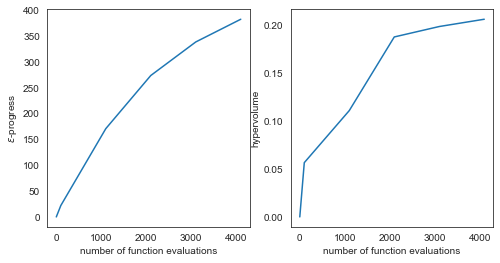

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

If we look at the above plots, we can see that neither hypervolume, nor $\epsilon$-progress has stablized. 5000 function evaluations is clearly not sufficient. Let's go to another extreme: 100.000. What happens in this case?

In [14]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    results, convergence = evaluator.optimize(nfe=100000, searchover='levers',
                                    epsilons=[0.125, 0.05, 0.01, 0.01],
                                    convergence=convergence_metrics,
                                    constraints=constraints)


[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/100000 nfe
[MainProcess/INFO] generation 5: 500/100000 nfe
[MainProcess/INFO] generation 10: 1000/100000 nfe
[MainProcess/INFO] generation 15: 1500/100000 nfe
[MainProcess/INFO] generation 20: 2000/100000 nfe
[MainProcess/INFO] generation 25: 2500/100000 nfe
[MainProcess/INFO] generation 30: 3000/100000 nfe
[MainProcess/INFO] generation 35: 3500/100000 nfe
[MainProcess/INFO] generation 40: 4000/100000 nfe
[MainProcess/INFO] generation 45: 4500/100000 nfe
[MainProcess/INFO] generation 50: 5000/100000 nfe
[MainProcess/INFO] generation 55: 5500/100000 nfe
[MainProcess/INFO] generation 60: 6000/100000 nfe
[MainProcess/INFO] generation 65: 6500/100000 nfe
[MainProcess/INFO] generation 70: 7000/100000 nfe
[MainProcess/INFO] generation 75: 7500/100000 nfe
[MainProcess/INFO] generation 80: 8000/100000 nfe
[MainProcess/INFO] generation 85: 8500/100000 nfe
[MainProcess/INFO] generation 90: 9000/100000 nfe
[MainProcess/INFO] gener

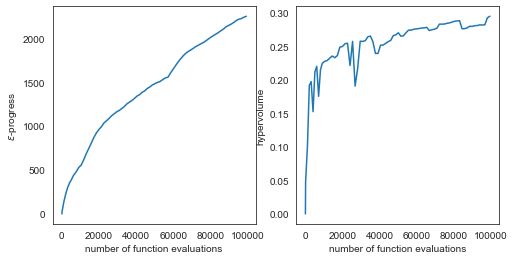

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

The runtime of this analysis has been substantial. Still, looking at the convergen graphs, hypervolume has more or less stablized, while $\epsilon$-progress only starts to stablize. This could be an argument for running the algorithm even longer (say 250.000 nfe). Establising the number of NFE is generally a form of trial and error. 

# The role of stochasticity
MOEAs use stochastics in crossover and mutation. Thus, the specific set of results will vary from one run of the algorithm to the next. Analogous to how you deal with stochasticitiy in discrete event models, it is best practice to run an MOEA multiple times using a different random seed. Next, you would combine the results from the different runs into a combined pareto approximate set. 


In [16]:
all_results = []

with MultiprocessingEvaluator(lake_model) as evaluator:
    for rep in range(5):
        # 5000 runs is clearly way to low, givent he convergence 
        # analysis above. this is only for demonstration purposes
        results = evaluator.optimize(nfe=5000, searchover='levers',
                                     epsilons=[0.125, 0.05, 0.01, 0.01],
                                     constraints=constraints)
        all_results.append(results)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/INFO] generation 5: 500/5000 nfe
[MainProcess/INFO] generation 10: 1000/5000 nfe
[MainProcess/INFO] generation 15: 1500/5000 nfe
[MainProcess/INFO] generation 20: 2000/5000 nfe
[MainProcess/INFO] generation 25: 2500/5000 nfe
[MainProcess/INFO] generation 30: 3000/5000 nfe
[MainProcess/INFO] generation 35: 3500/5000 nfe
[MainProcess/INFO] generation 40: 4000/5000 nfe
[MainProcess/INFO] generation 45: 4500/5000 nfe
[MainProcess/INFO] optimization completed, found 90 solutions
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/INFO] generation 5: 500/5000 nfe
[MainProcess/INFO] generation 10: 1000/5000 nfe
[MainProcess/INFO] generation 15: 1500/5000 nfe
[MainProcess/INFO] generation 20: 2000/5000 nfe
[MainProcess/INFO] generation 25: 2500/5000 nfe
[MainProcess/INFO] generation 30: 3000/5000 nfe
[MainProcess/INFO] generation 35: 3500/5000 nfe
[MainProcess/INFO] generation 40: 4000/5000 nfe
[MainP

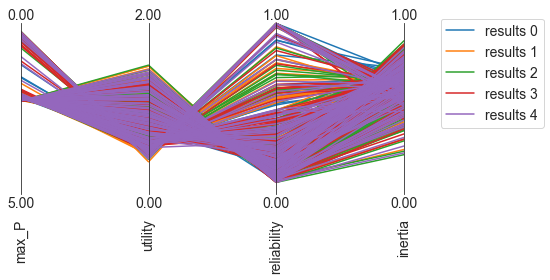

In [22]:
import pandas as pd
import seaborn as sns

limits = pd.DataFrame([[0,0,0,0],[5,2,1,1]], columns=['max_P', 'utility', 'reliability', 'inertia'])
axes = parcoords.ParallelAxes(limits)

for i, (result, color) in enumerate(zip(all_results, sns.color_palette())):
    outcomes = result.loc[:, ['max_P', 'utility', 'reliability', 'inertia']]
    axes.plot(outcomes, color=color, label='results {}'.format(i))

# we invert this axis so direction of desirability is the same  
axes.invert_axis('max_P') 
axes.legend()
plt.show()

# Using an alternative optimization algorithm

In this exercise, I recommend to use Platypus with the ε-NSGAII algorithm, since it is shown to outperform many MOEA’s. For other algortihms, see the documentation of Platypus. For a comparison of them, you can have a look at [Reed et al (2013)](http://dx.doi.org/10.1016/j.advwatres.2012.01.005).

In [23]:
from ema_workbench.em_framework.optimization import GenerationalBorg

with MultiprocessingEvaluator(lake_model) as evaluator:
    results, convergence = evaluator.optimize(nfe=50000, searchover='levers',
                                    epsilons=[0.125, 0.05, 0.01, 0.01],
                                    convergence=convergence_metrics,
                                    constraints=constraints,
                                    algorithm=GenerationalBorg,
                                    logging_freq=50)


[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/50000 nfe
[MainProcess/INFO] generation 50: 5027/50000 nfe
[MainProcess/INFO] generation 100: 10050/50000 nfe
[MainProcess/INFO] generation 150: 28227/50000 nfe
[MainProcess/INFO] generation 200: 46502/50000 nfe
[MainProcess/INFO] optimization completed, found 137 solutions
[MainProcess/INFO] terminating pool


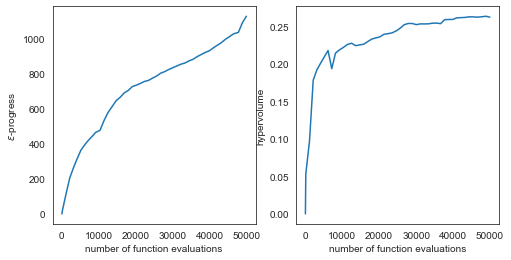

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()